In [2]:
import numpy as np
import gvar as gv
import matplotlib.pyplot as plt
import math
import lsqfit
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.fft import fft, fftfreq

In [3]:

import matplotlib as mpl
from  matplotlib import rc
import matplotlib.pyplot as plt


colorsrgb = [(0, 0, 0), (230, 159, 0), (86, 180, 233),
          (0, 158, 115), (240, 228, 66), (0, 114, 178),
          (213, 94, 0), (204, 121, 167)]

fmts = ['o', 'd', 's', '^', '<', '8', '6', 'd', 'x']
colors = [tuple([el / 255 for el in c]) for c in colorsrgb]

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams.keys()
# mpl.rcParams["text.fontset"] = "Times New Roman"
mpl.rcParams["mathtext.fontset"] = "stix"

In [22]:
def dft(points, num_mom):
    ret = []
    moms = np.linspace(0, num_mom - 1, num_mom) * 2 * np.pi / num_mom
    for i in range(0,num_mom):
        tmpre = 0.
        tmpim = 0.
        for j in range(0,len(points)):
            tmpre += points[j]*gv.cos(moms[i] * j)
            tmpim += points[j]*gv.sin(moms[i] * j)
        ret.append([tmpre,tmpim])
        
    return ret

In [23]:
data_file1 = open("ProcessedData/ProcessedData/m=2ns=4/finalreadoutdynamicdecouplingandrescaling_nairobi.csv")
data_file2 = open("ProcessedData/ProcessedData/m=2ns=4/finalreadoutnodynamicdecoupling_nairobi.csv")
data = np.loadtxt(data_file1)
data_file1.close()
data_gvar1 = gv.gvar(data[0],data[1:])
data = np.loadtxt(data_file2)
data_file2.close()
data_gvar2 = gv.gvar(data[0],data[1])

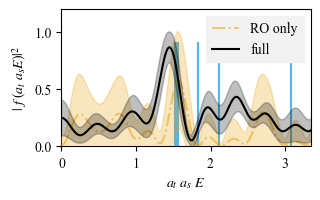

In [65]:
steps = 2000
trim = 20
exact_energies = np.array([1.51699095, 1.53537955, 1.56431981, 1.83537955, 1.83537955,
       2.1146886 , 3.08089841])

# exact_energies = np.array([1.4992986 , 1.5178302 , 1.54709375, 1.8178302 , 1.8178302 ,
#        2.09669824, 3.04606041])
data_fftfreq = np.linspace(0, steps - 1, steps) / steps
data_dft = dft(data_gvar1[:trim], steps)
data_dft_abs2 = np.array([i[0]**2. + i[1]**2. for i in data_dft])
data_dft_abs2 /= sum(data_dft_abs2)
data_dft_abs2_means1 = np.array([i.mean for i in data_dft_abs2])
data_dft_abs2_stdev1 = np.array([i.sdev for i in data_dft_abs2])

data_fftfreq = np.linspace(0, steps - 1, steps) / steps
data_dft = dft(data_gvar2[:trim], steps)
data_dft_abs2 = np.array([i[0]**2. + i[1]**2. for i in data_dft])
data_dft_abs2 /= sum(data_dft_abs2)
data_dft_abs2_means2 = np.array([i.mean for i in data_dft_abs2])
data_dft_abs2_stdev2 = np.array([i.sdev for i in data_dft_abs2])

plt.figure(figsize=(3.375, 3.375 / 1.6))

c2 = 1
mid1 = data_dft_abs2_means2
high1 = mid1 + data_dft_abs2_stdev2
low1 = mid1 - data_dft_abs2_stdev2
mid1 /= np.max(high1)
low1 /= np.max(high1)
high1 /= np.max(high1)
dtype = [('freq', float), ('high', float), ('low', float)]
arrh = np.array([(data_fftfreq[i], high1[i], low1[i]) for i in range(len(high1))], dtype=dtype)
arrh = np.sort(arrh, order=['freq'])
arr = np.array([list(arr_h) for arr_h in arrh])
plt.fill_between(arr[:, 0] * 2 * np.pi, arr[:, 1], arr[:, 2], color=list(colors[c2]) + [0.25], zorder= 15)
plt.plot(arr[:, 0] * 2 * np.pi, (arr[:, 1] + arr[:, 2]) / 2, color=list(colors[c2]) + [0.5], ls='-.', label='RO only', zorder=20)

mid2 = data_dft_abs2_means1
high2 = mid2 + data_dft_abs2_stdev1
low2 = mid2 - data_dft_abs2_stdev1
mid2 /= np.max(high2)
low2 /= np.max(high2)
high2 /= np.max(high2)
dtype = [('freq', float), ('high', float), ('low', float)]
arrh = np.array([(data_fftfreq[i], high2[i], low2[i]) for i in range(len(high2))], dtype=dtype)
arrh = np.sort(arrh, order=['freq'])
arr = np.array([list(arr_h) for arr_h in arrh])
plt.fill_between(arr[:, 0] * 2 * np.pi, arr[:, 1], arr[:, 2], color=list(colors[0]) + [0.25], zorder = 100)
plt.plot(arr[:, 0] * 2 * np.pi, (arr[:, 1] + arr[:, 2]) / 2, color='k', label='full', zorder=85)

for i in range(len(exact_energies)):
    plt.plot([exact_energies[i]] * 2, [0, 0.9], color=colors[2], zorder=0)
plt.xlabel(r'$a_t~a_s~E$')
plt.ylabel(r'$\vert ~f~(a_t~a_s E) \vert^2$')
plt.xlim(0, np.pi + 0.2)
plt.ylim(0, 1.2)
plt.legend(framealpha=1, shadow=False, edgecolor=(0.95, 0.95, 0.95),
           facecolor=(0.95, 0.95, 0.95), ncol=1, fancybox=False, )
plt.tight_layout()
plt.savefig('fourierns4m2v2.pdf')

In [15]:
def breitwigner(x, mass, width, amp):
    return amp / ((x ** 2 - mass ** 2) ** 2 + mass ** 2 * width ** 2)

In [248]:
steps = 2000
trim = 20
data_dft = np.array(dft(data_gvar1[:trim], steps))
data_dft = data_dft[:, 0] ** 2 + data_dft[:, 1] ** 2
data_dft /= sum(data_dft)
print(data_dft)
freqs = (np.linspace(0, steps - 1, steps) * 2 * np.pi / steps)[:1000]
gv_iter = gv.raniter(data_dft[:1000])
nboot = 500
ret_vals = np.zeros(nboot)
ret_vals_w = np.zeros(nboot)
for i in range(nboot):
    data_points = next(gv_iter)
    
    def opt_func(p):
        mass, width, amp = p
        bw = breitwigner(freqs, mass, width, amp)
        norm = data_points @ data_points
        return (bw - data_points) @ (bw - data_points)
    
    ret = minimize(opt_func, np.array([1.5, 0.1, 1]), bounds=[(1, 1.5), (0, np.pi), (0, np.inf)])
    ret_vals[i] += (ret.x[0])
    ret_vals_w[i] += ret.x[1]
    print('{} is done'.format(i + 1))
    
    

[0.00045(28) 0.00045(28) 0.00045(28) ... 0.00045(28) 0.00045(28)
 0.00045(28)]
1 is done
2 is done
3 is done
4 is done
5 is done
6 is done
7 is done
8 is done
9 is done
10 is done
11 is done
12 is done
13 is done
14 is done
15 is done
16 is done
17 is done
18 is done
19 is done
20 is done
21 is done
22 is done
23 is done
24 is done
25 is done
26 is done
27 is done
28 is done
29 is done
30 is done
31 is done
32 is done
33 is done
34 is done
35 is done
36 is done
37 is done
38 is done
39 is done
40 is done
41 is done
42 is done
43 is done
44 is done
45 is done
46 is done
47 is done
48 is done
49 is done
50 is done
51 is done
52 is done
53 is done
54 is done
55 is done
56 is done
57 is done
58 is done
59 is done
60 is done
61 is done
62 is done
63 is done
64 is done
65 is done
66 is done
67 is done
68 is done
69 is done
70 is done
71 is done
72 is done
73 is done
74 is done
75 is done
76 is done
77 is done
78 is done
79 is done
80 is done
81 is done
82 is done
83 is done
84 is done
85 is 

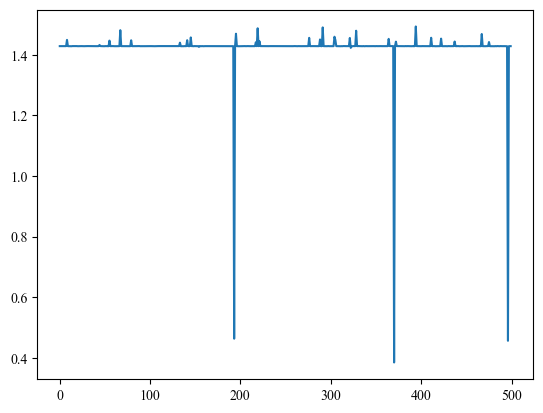

In [249]:
plt.plot(ret_vals_w)

In [250]:
print(np.mean(ret_vals), np.mean(ret_vals_w))

1.4910580582819293 1.423998084862701


In [240]:
def fcn2(x, p):
    ret = gv.cos(p[0] * x) * gv.exp(p[1] * x) * p[2]
    return ret

fit = lsqfit.nonlinear_fit(data=(np.linspace(1, 20, 20)[:10], data_gvar1[:10]),
                           fcn=fcn2, prior=[gv.gvar(np.mean(ret_vals), np.mean(ret_vals_w)), gv.gvar(0, 20),
                                            gv.gvar(1, 1)])
#                            bounds=[(-np.inf, np.inf), (-np.inf, np.inf),
#                                    (-1, 1)])
print(fit)

Least Square Fit:
  chi2/dof [dof] = 7e+02 [10]    Q = 0    logGBF = -3491.8

Parameters:
              0      1.987 (12)      [  1.8 (1.4) ]  
              1       0.95 (18)      [     0 (20) ]  
              2   -0.00017 (28)      [  1.0 (1.0) ]  *

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 25/0.0)
  fitter = scipy_least_squares    method = trf



(-2.0, 2.0)

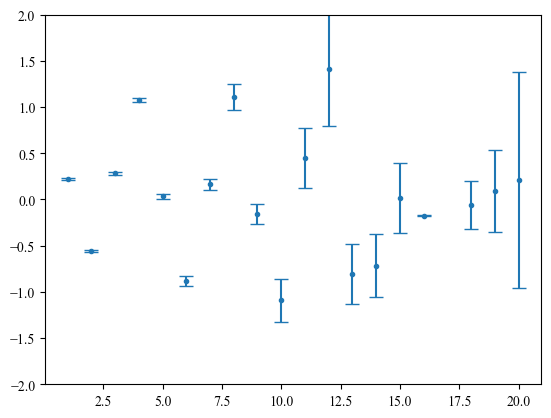

In [229]:
plt.errorbar(np.linspace(1, 20, 20), gv.mean(data_gvar1), yerr=gv.sdev(data_gvar1),
             capsize=5, fmt='.')
xpts = np.linspace(0, 20, 100)
ypts = fcn2(xpts, fit.p)
ym = gv.mean(ypts)
dy = gv.sdev(ypts)
plt.ylim(-2, 2)
# plt.fill_between(xpts, ym + dy, ym - dy, facecolor=colors[1])

<ErrorbarContainer object of 3 artists>

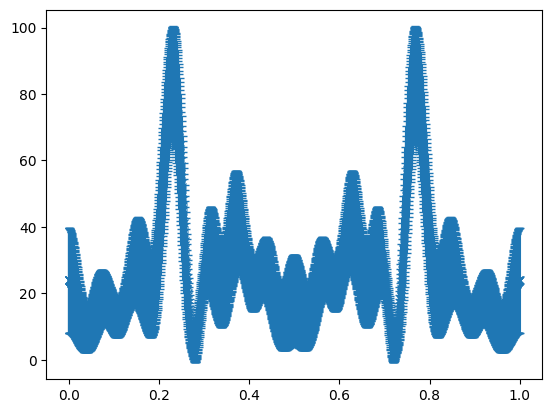

In [7]:
plt.errorbar(data_fftfreq,data_dft_abs2_means,yerr=data_dft_abs2_stdev,fmt="x", capsize=3)

In [124]:
y = np.array(data_dft_abs2) ** 0.5
x = data_fftfreq

prior = {}
prior['a'] = gv.gvar(0.15,0.15)
prior['b'] = gv.gvar(0.01,0.01)
prior['c'] = gv.gvar(1,0.5)

def testfun(x, p):
    peak1 = p['c'] / ((x + p['a']) ** 2 + p['b'])
    peak2 = 0#p['c'] / ((x - p['a']) ** 2 + p['b'])
    ans = peak1 + peak2 + p['d']
#     ans = p['c'] * (1/((x+p['a'])**2.+p['b']) + 1/((x-p['a'])**2.+p['b'])) + p['d']
    return ans

def testfun2(x, p):
    peak1 = p['c'] / ((x + p['a']) ** 2 + p['b'])
    peak2 = p['c'] / ((x - p['a']) ** 2 + p['b'])
    ans = peak1 + peak2 + p['d']
#     ans = p['c'] * (1/((x+p['a'])**2.+p['b']) + 1/((x-p['a'])**2.+p['b'])) + p['d']
    return ans
    

fit = lsqfit.nonlinear_fit(data=(x[1:10], y[1:10]), p0={'a': 0.15, 'b': 0.01, 'c': 1, 'd': 1},
                           fcn=testfun, debug=True)
fit2 = lsqfit.nonlinear_fit(data=(x, y), p0=gv.mean(fit.p), fcn=testfun2)
print(fit2)
print(fit.format(maxline=True))       # print standard summary of fit

Least Square Fit (no prior):
  chi2/dof [dof] = 2.9 [16]    Q = 0.00011    

Parameters:
              a   -0.15141 (48)      [   -0.153301 +- inf ]  
              b   0.000786 (31)      [ 0.000762001 +- inf ]  
              c    0.01124 (58)      [   0.0111975 +- inf ]  
              d      0.042 (54)      [    0.230253 +- inf ]  

Settings:
  svdcut/n = 1e-12/9    tol = (1e-08,1e-10,1e-10*)    (itns/time = 5/0.0)
  fitter = scipy_least_squares    method = trf

Least Square Fit (no prior):
  chi2/dof [dof] = 5.6 [5]    Q = 3.9e-05    

Parameters:
              a   -0.15330 (69)      [ 0.15 +- inf ]  
              b   0.000762 (36)      [ 0.01 +- inf ]  
              c    0.01120 (65)      [    1 +- inf ]  
              d      0.230 (73)      [    1 +- inf ]  

Fit:
     x[k]          y[k]     f(x[k],p)
-------------------------------------
     0.05     0.70 (19)    1.210 (70)  **
      0.1     2.97 (19)     3.34 (15)  *
     0.15    15.12 (22)    14.72 (20)  *
      0.2     4.

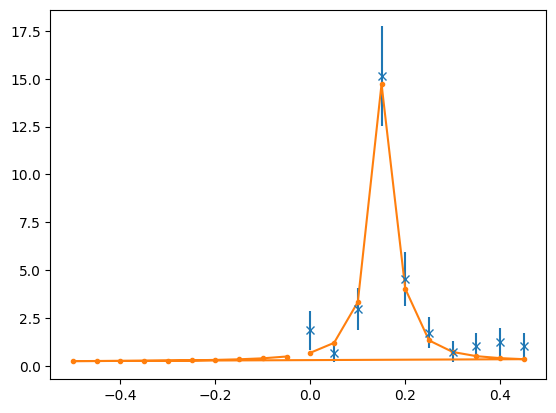

In [125]:
s0, s1 = 0, 10
plt.errorbar(data_fftfreq[s0:s1],np.array(gv.mean(data_dft_abs2)[s0:s1]) ** 0.5,yerr=gv.sdev(data_dft_abs2[s0:s1]) ** 0.5, fmt="x")
plt.plot(data_fftfreq, testfun(data_fftfreq, gv.mean(fit.p)), '.-')
# plt.plot(data_fftfreq, testfun(data_fftfreq, {'a': 0.15, 'b': 0.01, 'c': 0.001, 'd': 1}), '.')

In [ ]:
testfun()